In [1]:
import warnings
import sys
import os
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from pathlib import Path
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error, mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]

error_feature=["leaves_per_class.mean",'Group Size Disparity', 'Prevalence Disparity','disparate_parity', 'equal_opportunity']
#Target Labels 'Disparate Parity', 'Equal Opportunity'
bias_score_key=["individual_fairness","group_fairness"]
target_names = ['Individual Fairness', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict = dict(zip(bias_score_key, target_names_w))

In [4]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
X=X.drop(error_feature,axis=1)
Y=df[bias_score_key]

In [5]:
df.sort_values("disparate_parity")

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean,Group Size Disparity,Prevalence Disparity,equal_opportunity,disparate_parity,individual_fairness,group_fairness
11178,0.028369,4.169925,0.450159,0.889191,7.822481e-02,0.009839,2.064637,0.360634,0.930325,0.309524,...,0.044973,0.006434,0.111111,0.416984,0.423557,0.008473,0.000000,0.000000,0.809801,0.809801
16121,0.006873,4.247927,0.589481,0.753067,2.004143e-01,0.006168,1.506134,0.458487,0.893997,0.455325,...,0.033754,0.006811,0.125000,0.477792,0.435487,0.000901,0.000000,0.000000,0.224457,0.224457
11180,0.028369,4.169925,0.450159,0.889191,7.822481e-02,0.009839,2.064637,0.360634,0.930325,0.309524,...,0.044973,0.006434,0.111111,0.416984,0.596359,0.009121,0.000000,0.000000,0.809801,1.242838
11179,0.028369,4.169925,0.450159,0.889191,7.822481e-02,0.009839,2.064637,0.360634,0.930325,0.309524,...,0.044973,0.006434,0.111111,0.416984,0.736331,0.006352,0.000000,0.000000,0.809801,0.809801
14345,0.013304,4.000000,0.434167,0.908047,6.340953e-02,0.010791,2.108420,0.403187,0.927511,0.325417,...,0.043233,0.008074,0.111111,0.363333,0.194355,0.013026,0.000000,0.000000,0.806490,0.806490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19980,0.999996,4.321928,0.992840,1.000000,1.097393e-06,0.051111,1.000000,0.184498,0.827018,0.985309,...,0.028313,0.029284,0.250000,0.992840,0.000247,0.492839,0.926168,0.997781,0.019400,0.019400
19979,0.999996,4.321928,0.992840,1.000000,1.097393e-06,0.051111,1.000000,0.184498,0.827018,0.985309,...,0.028313,0.029284,0.250000,0.992840,0.403243,0.492747,0.728352,0.997788,0.019400,0.019400
13191,0.999997,4.247926,0.995070,1.000000,1.586987e-07,0.051572,1.000000,0.183509,0.824175,0.990845,...,0.052211,0.057719,0.500000,0.995070,0.000000,0.495070,0.995207,0.998024,0.003631,0.003631
9550,0.425360,4.459432,0.994909,0.999998,4.231396e-06,0.031133,0.999998,0.394824,0.809100,0.989182,...,0.042606,0.040270,0.083333,0.994909,0.396321,0.495028,0.995636,0.998409,0.004567,0.004567


In [6]:
df.sort_values("group_fairness")

,attr_conc.mean,attr_ent.mean,best_node.mean,c1,c2,class_conc.mean,class_ent,cls_coef,density,elite_nn.mean,...,tree_imbalance.mean,tree_shape.mean,var_importance.mean,worst_node.mean,Group Size Disparity,Prevalence Disparity,equal_opportunity,disparate_parity,individual_fairness,group_fairness
11719,0.999998,4.000000,0.993182,0.999985,4.132146e-05,0.064986,0.999985,0.186133,0.827738,0.987273,...,0.067875,0.076065,0.166667,0.993182,1.277208,0.240883,0.505593,0.324224,0.018997,-0.059135
11720,0.999998,4.000000,0.993182,0.999985,4.132146e-05,0.064986,0.999985,0.186133,0.827738,0.987273,...,0.067875,0.076065,0.166667,0.993182,1.087342,0.285995,0.505593,0.468254,0.018997,-0.040778
13513,0.999996,4.321928,0.995595,1.000000,1.020408e-06,0.051710,1.000000,0.182523,0.824633,0.990952,...,0.056919,0.049253,0.166667,0.995595,1.199286,0.425246,0.598088,0.690552,0.007196,-0.039756
7609,0.654952,4.584962,0.986291,1.000000,3.157756e-07,0.033131,1.000000,0.322430,0.823491,0.978808,...,0.031296,0.014372,0.090909,0.986291,1.541987,0.410856,0.005577,0.571697,0.035486,-0.034283
12332,0.999997,4.087461,0.992545,0.518285,7.415571e-01,0.055653,0.518285,0.199173,0.837657,0.985455,...,0.046519,0.058012,0.333333,0.992545,0.725572,0.046758,0.075768,0.082357,0.009912,-0.031791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11773,0.008865,4.169924,0.302656,0.977741,1.657920e-02,0.009874,2.527425,0.374663,0.944347,0.210156,...,0.044787,0.006108,0.142857,0.300312,0.861816,0.013133,0.159246,0.066452,1.542377,2.278060
12326,0.006839,4.169924,0.430328,0.860736,9.974572e-02,0.005920,2.224971,0.449839,0.932944,0.310164,...,0.045184,0.005966,0.111111,0.314754,0.892634,0.064360,0.118109,0.085631,1.799433,2.352159
16979,0.011901,4.087462,0.405517,0.858266,1.118249e-01,0.012455,2.218587,0.412603,0.925579,0.293103,...,0.037547,0.007852,0.100000,0.361207,0.630666,0.035257,0.515949,0.078493,1.860144,2.384954
1791,0.009976,4.392317,0.392277,0.817110,1.061757e-01,0.004091,2.112199,0.426019,0.937980,0.254554,...,0.039191,0.004457,0.055556,0.323663,0.848475,0.041189,0.095157,0.083198,1.636548,2.400344


In [5]:
X.columns

Index(['attr_conc.mean', 'attr_ent.mean', 'best_node.mean', 'c1', 'c2',
       'class_conc.mean', 'class_ent', 'cls_coef', 'density', 'elite_nn.mean',
       'eq_num_attr', 'f1.mean', 'f1v.mean', 'f2.mean', 'f3.mean', 'f4.mean',
       'hubs.mean', 'joint_ent.mean', 'l1.mean', 'l2.mean', 'l3.mean',
       'leaves', 'leaves_branch.mean', 'leaves_corrob.mean',
       'leaves_homo.mean', 'linear_discr.mean', 'lsc', 'mut_inf.mean', 'n1',
       'n2.mean', 'n3.mean', 'n4.mean', 'naive_bayes.mean', 'nodes',
       'nodes_per_attr', 'nodes_per_inst', 'nodes_per_level.mean',
       'nodes_repeated.mean', 'ns_ratio', 'one_nn.mean', 'random_node.mean',
       't1', 't2', 't3', 't4', 'tree_depth.mean', 'tree_imbalance.mean',
       'tree_shape.mean', 'var_importance.mean', 'worst_node.mean'],
      dtype='object')

In [6]:
Y.columns

Index(['individual_fairness', 'group_fairness'], dtype='object')

In [34]:
cv_result_path="experiment_result/Q6_result.csv"
avg_result_path="experiment_result/Q6_average_result.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)

cv_avg_result_df=pd.DataFrame()
if Path(avg_result_path).is_file():
    cv_avg_result_df=pd.read_csv(avg_result_path,header=0,index_col=0)

In [12]:
compare_result_path="experiment_result/Q2_result.csv"
compare_avg_path="experiment_result/Q2_average_result.csv"

compare_result_df=pd.DataFrame()
if Path(compare_result_path).is_file():
    compare_result_df=pd.read_csv(compare_result_path,header=0,index_col=0)

compare_avg_df=pd.DataFrame()
if Path(compare_avg_path).is_file():
    compare_avg_df=pd.read_csv(compare_avg_path,header=0,index_col=0)

In [9]:
def symmetry_mean_aboslute_percentage_error(truth,pred):
    smape = np.abs(pred - truth) / (np.abs(truth)+np.abs(pred))*2
    output_errors = np.average(smape, axis=0)
    return output_errors

In [10]:
def cross_validatae(model, name, target,fold_settings={}):
    cv_result=[]
    #fold_settings are parameters to specified the KFold used to create training testing split in all folds
    k_fold=KFold(**fold_settings)
    for index,(train_index,test_index) in enumerate(tqdm(k_fold.split(X,Y), total=k_fold.get_n_splits(), desc=target)):

        #Train models and produce predictions based on training and testing split
        model.fit(X.loc[train_index],Y.loc[train_index][target])
        pred=model.predict(X.loc[test_index])
        truth=Y.loc[test_index][target]

        #Calculate the metrics
        mae=mean_absolute_error(truth,pred)
        mse=mean_squared_error(truth,pred)
        rmse=root_mean_squared_error(truth,pred)
        mape=mean_absolute_percentage_error(truth,pred)
        smape=symmetry_mean_aboslute_percentage_error(truth,pred)
        msle=mean_squared_log_error(np.abs(truth),np.abs(pred))
        cv_result.append({
            "Model":name,
            "Fold":index,
            "label": target,
            "MAE":mae,
            "MSE":mse,
            "RMSE":rmse,
            "MAPE":mape,
            "SMAPE":smape,
            "MSLE":msle
        })
    
    #Output results as Dataframe
    result_df=pd.DataFrame(cv_result)
    average_row={"Model":name,"label":target}
    average_row.update(result_df.drop(columns=["Model","Fold","label"]).agg(np.average).to_dict())
    average_df=pd.DataFrame([average_row],index=[name])
    return result_df,average_df

In [11]:
# Perform Cross Validation for each model settings 
def evaluate_model(model,name,fold_settings={}):
    global cv_result_df
    global cv_avg_result_df
    for bs in bias_score_key:
        if bs in cv_result_df[cv_result_df["Model"]==name]["label"].unique():
            print(f"{name} for {bs} has already been tested")
            continue
        cv_df,avg_df=cross_validatae(model,name,bs,fold_settings)
        cv_result_df=pd.concat([cv_result_df,cv_df],axis=0).reset_index(drop=True)
        cv_result_df.to_csv(cv_result_path)
        cv_avg_result_df=pd.concat([cv_avg_result_df,avg_df],axis=0).reset_index(drop=True)
        cv_avg_result_df.to_csv(avg_result_path)
        print(f"CV on model trained to predict {bs} has finished")

In [12]:
#Universal KFold training and setting split settings
fold_settings={
    "n_splits":10, 
    "shuffle":True,
    "random_state":420
}

In [58]:
evaluate_model(DummyRegressor(strategy="mean"),"NaiveMean",fold_settings)

NaiveMean for individual_fairness has already been tested
NaiveMean for group_fairness has already been tested


In [59]:
evaluate_model(LinearRegression(),"LinearRegression",fold_settings)

LinearRegression for individual_fairness has already been tested
LinearRegression for group_fairness has already been tested


In [60]:
evaluate_model(LassoCV(cv=KFold(n_splits=5,shuffle=True,random_state=500)),"Lasso",fold_settings)

Lasso for individual_fairness has already been tested
Lasso for group_fairness has already been tested


In [14]:
#XGBoost, LightGBM, RandomForest and MLP requires hyperparameters tuning, We use GridSearchCV to tune.
#Based on our understanding of the method, there are not risk of leakage of testing data during model training.
xgboost_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[2,5,10,15,20],
    "learning_rate":[0.01,0.3, 0.5]
}
evaluate_model(GridSearchCV(XGBRegressor(objective="reg:squarederror", n_jobs=8, seed=600, device="gpu")
            ,xgboost_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=600),scoring="neg_mean_squared_error", n_jobs=5)
               ,"XGBoost",fold_settings)

individual_fairness: 100%|██████████| 10/10 [4:53:24<00:00, 1760.47s/it] 


CV on model trained to predict individual_fairness has finished


group_fairness: 100%|██████████| 10/10 [5:26:23<00:00, 1958.40s/it] 

CV on model trained to predict group_fairness has finished


In [64]:
lightgbm_parameters={
    "n_estimators":range(50,300,50),
    "max_depth":[5,10,20,30,40],
    "learning_rate":[0.01,0.1, 0.5],
}
evaluate_model(GridSearchCV(LGBMRegressor(objective="regression", n_jobs=8, random_state =700, device_type ="gpu",verbosity=-1)
            ,lightgbm_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=700),scoring="neg_mean_squared_error", n_jobs=5)
               ,"LightGBM",fold_settings)

individual_fairness: 100%|██████████| 10/10 [1:03:24<00:00, 380.48s/it]


CV on model trained to predict individual_fairness has finished


group_fairness: 100%|██████████| 10/10 [1:03:26<00:00, 380.64s/it]

CV on model trained to predict group_fairness has finished


In [65]:
randomforest_parameters={
    "n_estimators":range(25,150,25),
    "max_depth":[5,10,20,30,40],
    "max_features":[1,0.5, "sqrt"],
}
evaluate_model(GridSearchCV(RandomForestRegressor( n_jobs=8, random_state =800)
            ,randomforest_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=800),scoring="neg_mean_squared_error", n_jobs=5)
               ,"RandomForest",fold_settings)

individual_fairness: 100%|██████████| 10/10 [52:17<00:00, 313.80s/it]


CV on model trained to predict individual_fairness has finished


group_fairness: 100%|██████████| 10/10 [54:48<00:00, 328.86s/it]

CV on model trained to predict group_fairness has finished


In [66]:
MLP_parameters={
    "hidden_layer_sizes":[(50,),(100,),(25,25),(75,25),(25,50,25),(10,30,10)],
    "solver":['sgd', 'adam'],
    "activation":['relu','logistic'],
    "learning_rate_init": [0.001,0.01,0.1]
}

evaluate_model(GridSearchCV(MLPRegressor(random_state =900,batch_size=20)
            ,MLP_parameters,cv=KFold(n_splits=5,shuffle=True,random_state=900),scoring="neg_mean_squared_error", n_jobs=5)
               ,"MLP",fold_settings)

individual_fairness: 100%|██████████| 10/10 [2:05:22<00:00, 752.25s/it] 


CV on model trained to predict individual_fairness has finished


group_fairness: 100%|██████████| 10/10 [2:05:31<00:00, 753.17s/it] 

CV on model trained to predict group_fairness has finished


In [36]:
cv_fairness_result_df=cv_result_df[cv_result_df["label"].isin(bias_score_key)]
compare_fairness_result_df=compare_result_df[compare_result_df["label"].isin(bias_score_key)][compare_result_df["Model"]!="NaiveNormal"]

In [18]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']
model_colors = dict(zip(cv_fairness_result_df['Model'].unique(), COLORS))

In [50]:
def display_full_result(df,metrics,save_path="", figwidth=8, trim_y=True):
    fig, axes = plt.subplots(1, len(df['label'].unique()), figsize=(figwidth,0.8), sharey=False)
    for idx, target in enumerate(df['label'].unique()):
        sns.barplot(data=df[df['label']==target], x='Model', y=metrics, ax=axes[idx], 
                    palette=model_colors, hue='Model', legend=False if idx!=1 else 'brief')
        axes[idx].set_title(target_names_dict[target])
        # axes[idx].set_xlabel(metrics)
        axes[idx].set_xticks([], [])
        if trim_y:
            axes[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        if idx>0: axes[idx].set_ylabel('')
    # axes[2].legend(ncol=4, loc='upper center', bbox_to_anchor=(1.2, -0.4), frameon=False)
    axes[1].legend(ncol=1, loc='upper left', bbox_to_anchor=(1.15, 1.7), frameon=False)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

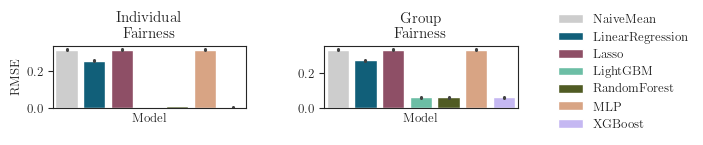

In [41]:
display_full_result(cv_fairness_result_df,"RMSE", figwidth=6)

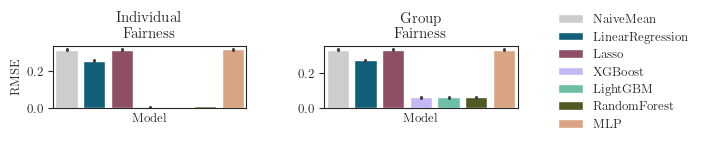

In [42]:
display_full_result(compare_fairness_result_df,"RMSE", figwidth=6)

In [47]:
Best_Model=["XGBoost","LightGBM","RandomForest"]
cv_fairness_result_df=cv_result_df[cv_result_df["label"].isin(bias_score_key)][cv_result_df["Model"].isin(Best_Model)]
compare_fairness_result_df=compare_result_df[compare_result_df["label"].isin(bias_score_key)][compare_result_df["Model"].isin(Best_Model)]

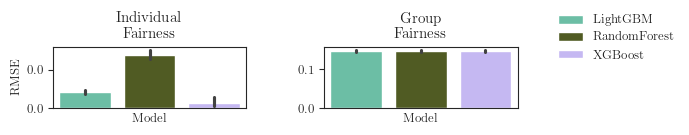

In [48]:
display_full_result(cv_fairness_result_df,"RMSE", figwidth=6)

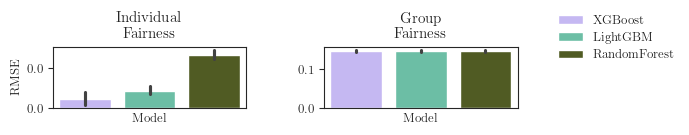

In [49]:
display_full_result(compare_fairness_result_df,"RMSE", figwidth=6)

### Which features are important if we remove classes_per_leaf for Group Fairness?

In [11]:
lightGBM_params={
    "objective":"regression", 
    "n_jobs":8, 
    "random_state":700, 
    "device_type":"gpu",
    "verbosity":-1,
    "n_estimators":50,
    "max_depth":5,
    "learning_rate":0.01,
    "importance_type":"split"
}

In [18]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
X=X.drop(['Group Size Disparity', 'Prevalence Disparity','disparate_parity', 'equal_opportunity'],axis=1)
Y=df[bias_score_key]

In [26]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['group_fairness'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y['group_fairness'].loc[mask], best_model.predict(X.loc[mask]))

    # drop overused feature
    X_sam = X_sam.drop(["leaves_per_class.mean"], axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('group_fairness', seed)] = best_model
    rmse_without = root_mean_squared_error(Y['group_fairness'].loc[mask], best_model.predict(X.drop(["leaves_per_class.mean"], axis=1).loc[mask]))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

Seed: 0  | RMSE all:  0.27014318870394327  | RMSE without:  0.27357207930572647  | Increase (in %):  1.269286343377328
Seed: 1  | RMSE all:  0.27382259502326434  | RMSE without:  0.2775901565539834  | Increase (in %):  1.3759133100023968
Seed: 2  | RMSE all:  0.2767348717857629  | RMSE without:  0.28068686415263416  | Increase (in %):  1.4280789194976287
Seed: 3  | RMSE all:  0.2745008305275868  | RMSE without:  0.2791709252397992  | Increase (in %):  1.7013044016065657
Seed: 4  | RMSE all:  0.27877740098831394  | RMSE without:  0.28084606500759246  | Increase (in %):  0.7420486782446319
Seed: 5  | RMSE all:  0.27159158665815913  | RMSE without:  0.2753753444598867  | Increase (in %):  1.3931793132053196
Seed: 6  | RMSE all:  0.2799245717814347  | RMSE without:  0.2817536237861494  | Increase (in %):  0.6534088783541289
Seed: 7  | RMSE all:  0.27480506142009953  | RMSE without:  0.27751512258922256  | Increase (in %):  0.986175856848617
Seed: 8  | RMSE all:  0.27577092165191464  | RMSE

In [30]:
# average feature importance over all seeds
avg_fi = np.array([models[('group_fairness', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(["leaves_per_class.mean"], axis=1).columns[sorted_indices]

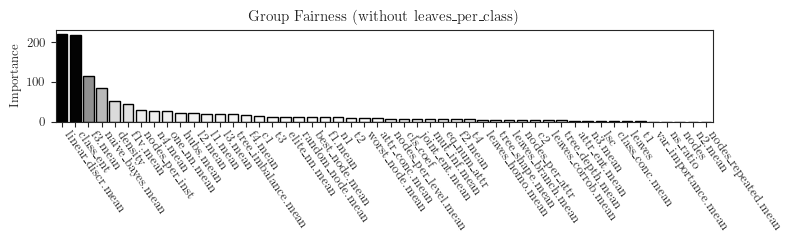

In [45]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title('Group Fairness (without leaves\_per\_class)')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig('Plots/Q4/feature_importance_group_fitness_without_leaves_per_class.pdf', bbox_inches='tight')
plt.show()

### What if we remove eq_num_attr for Disparate Parity?

In [53]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(['Group Size Disparity', 'Prevalence Disparity','group_fairness', 'equal_opportunity', 'individual_fairness', 'disparate_parity'],axis=1)
Y=df['disparate_parity']

In [54]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y.loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y.loc[mask], best_model.predict(X.loc[mask]))

    # drop overused feature
    X_sam = X_sam.drop(["eq_num_attr"], axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('disparate_parity', seed)] = best_model
    rmse_without = root_mean_squared_error(Y.loc[mask], best_model.predict(X.drop(["eq_num_attr"], axis=1).loc[mask]))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

Seed: 0  | RMSE all:  0.1444496534970936  | RMSE without:  0.14514604366740083  | Increase (in %):  0.482098885977074
Seed: 1  | RMSE all:  0.1453918390021011  | RMSE without:  0.14606288557367283  | Increase (in %):  0.4615434925216438
Seed: 2  | RMSE all:  0.14499200413478133  | RMSE without:  0.14493430115519343  | Increase (in %):  -0.03979735291765758
Seed: 3  | RMSE all:  0.1446894908329298  | RMSE without:  0.14568785252402316  | Increase (in %):  0.6900029057716026
Seed: 4  | RMSE all:  0.1431292504479877  | RMSE without:  0.14397457504928973  | Increase (in %):  0.5906022693867389
Seed: 5  | RMSE all:  0.1432377066954151  | RMSE without:  0.14342100668018012  | Increase (in %):  0.12796908648837274
Seed: 6  | RMSE all:  0.145773748017714  | RMSE without:  0.14611798649909627  | Increase (in %):  0.23614572998454647
Seed: 7  | RMSE all:  0.14456755091843848  | RMSE without:  0.14466786520184766  | Increase (in %):  0.06938921132154348
Seed: 8  | RMSE all:  0.1475216970174783  |

In [55]:
# average feature importance over all seeds
avg_fi = np.array([models[('disparate_parity', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(["eq_num_attr"], axis=1).columns[sorted_indices]

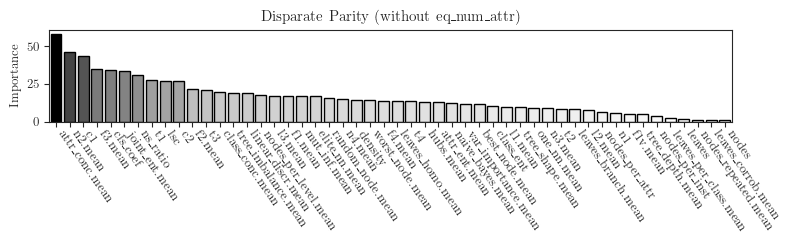

In [56]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title('Disparate Parity (without eq\_num\_attr)')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig('Plots/Q4/feature_importance_disparate_parity_without_eq_num_attr.pdf', bbox_inches='tight')
plt.show()